<a href="https://colab.research.google.com/github/Spandana-korabandi/cnn/blob/main/Handwritten_digits_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pickle
import tensorflow as tf #added tensorflow
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta, Adam, SGD
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D,BatchNormalization, Activation

from keras.models import Sequential
from keras.losses import categorical_crossentropy

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/MyDrive/Colab Notebooks") # might have to change path to point to your Colab Notebooks folder

Mounted at /content/gdrive


Number of classes: 10
Example of handwritten digit with correlated noise: 



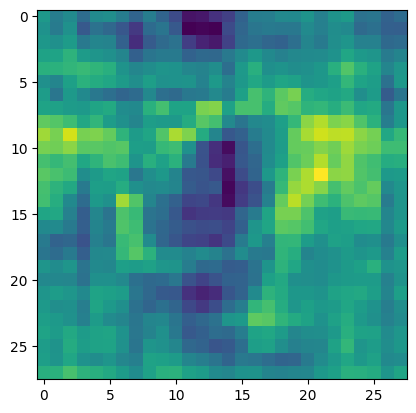

Class: 9

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


In [ ]:
data = np.load('./MNIST_CorrNoise.npz')

x_train = data['x_train']
y_train = data['y_train']

num_cls = len(np.unique(y_train))
print('Number of classes: ' + str(num_cls))

print('Example of handwritten digit with correlated noise: \n')

k = 3000
plt.imshow(np.squeeze(x_train[k,:,:]))
plt.show()
print('Class: '+str(y_train[k])+'\n')

# RESHAPE and standarize
x_train = np.expand_dims(x_train/255,axis=3)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_cls)

print('Shape of x_train: '+str(x_train.shape))
print('Shape of y_train: '+str(y_train.shape))

In [ ]:
#TRAINING

model_name='CNN' # To compare models, you can give them different names

pweight='./weights/weights_' + model_name  + '.keras' # changed to .keras from .hdf5

if not os.path.exists('./weights'):
  os.mkdir('./weights')

## EXPLORE VALUES AND FIND A GOOD SET
b_size = 80 # batch size
val_split = 0.1 # percentage of samples used for validation (e.g. 0.5)
ep = 60 # number of epochs

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ CONV1 (Conv2D)                       │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MAX_POOL1 (MaxPooling2D)             │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ NORM1 (BatchNormalization)           │ (None, 13, 13, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONV2 (Conv2D)                       │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MAX_POOL2 (MaxPooling2D)             │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ NORM2 (BatchNormalization)           │ (None, 5, 5, 128)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONV3 (Conv2D)                       │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONV4 (Conv2D)                       │ (None, 3, 3, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONV5 (Conv2D)                       │ (None, 3, 3, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MAX_POOL3 (MaxPooling2D)             │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ NORM3 (BatchNormalization)           │ (None, 3, 3, 256)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONV6 (Conv2D)                       │ (None, 3, 3, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONV7 (Conv2D)                       │ (None, 3, 3, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONV8 (Conv2D)                       │ (None, 3, 3, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MAX_POOL4 (MaxPooling2D)             │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC6 (Dense)                          │ (None, 1024)                │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC7 (Dense)                          │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC8 (Dense)                          │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,120,586 (15.72 MB)

 Trainable params: 4,119,690 (15.72 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/60
772/772 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.3550 - loss: 1.8257
Epoch 1: val_loss improved from inf to 0.82356, saving model to ./weights/weights_CNN.keras
772/772 ━━━━━━━━━━━━━━━━━━━━ 224s 289ms/step - accuracy: 0.3552 - loss: 1.8251 - val_accuracy: 0.7165 - val_loss: 0.8236
Epoch 2/60
772/772 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7953 - loss: 0.6147
Epoch 2: val_loss improved from 0.82356 to 0.79097, saving model to ./weights/weights_CNN.keras
772/772 ━━━━━━━━━━━━━━━━━━━━ 255s 280ms/step - accuracy: 0.7953 - loss: 0.6147 - val_accuracy: 0.7340 - val_loss: 0.7910
Epoch 3/60
772/772 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8615 - loss: 0.4133
Epoch 3: val_loss improved from 0.79097 to 0.64110, saving model to ./weights/weights_CNN.keras
772/772 ━━━━━━━━━━━━━━━━━━━━ 218s 283ms/step - accuracy: 0.8615 - loss: 0.4133 - val_accuracy: 0.8007 - val_loss: 0.6411
Epoch 4/60
772/772 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8902 - loss: 0.3233
E

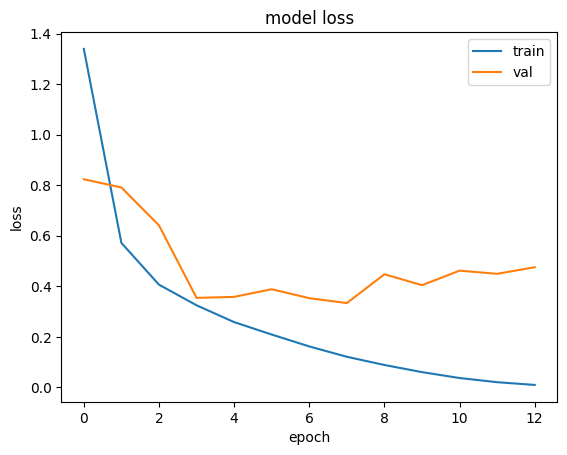

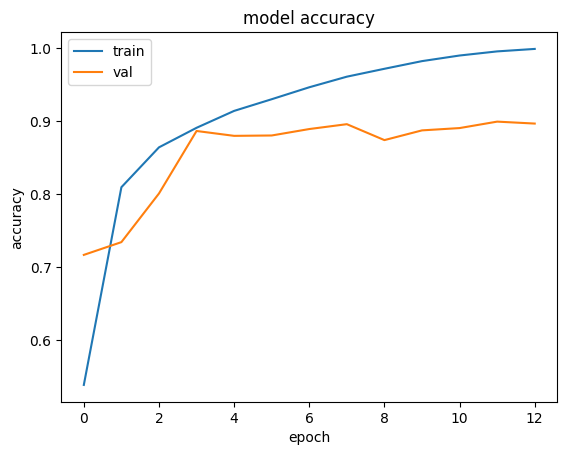

In [ ]:
input_shape = x_train.shape[1:4] #(28,28,1)
model = Sequential()

## EXPLORE LAYERS, # CHANNELS... Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D
## SEE KERAS MANUAL https://keras.io/layers/about-keras-layers/
model.add(Conv2D(1, kernel_size=(3, 3), activation='relu', input_shape=input_shape)) # explore num channels and adding more layers
model.add(Flatten()) # transforms matrix feature map to vector for dense layer (fully connected)
##
model.add(Dense(num_cls, activation='softmax')) # This is a necessary output layer, however, you can add more dense layers before with different activation functions

model2 = Sequential()

model2.add(Conv2D(64,kernel_size=(3, 3), activation='relu', input_shape=input_shape, name="CONV1") ) # CONV1

model2.add(MaxPooling2D(pool_size=(2, 2), name="MAX_POOL1")) # MAX POOL1

model2.add(BatchNormalization(name="NORM1")) # NORM1

model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name="CONV2"))# CONV2

#model2.add(Conv2D( 256, kernel_size=(3, 3), activation='relu', name="CONV3")) # CONV3

model2.add(MaxPooling2D(pool_size=(2, 2), name="MAX_POOL2")) # MAX POOL2

model2.add(BatchNormalization(name="NORM2")) # NORM2

model2.add(Conv2D( 256,kernel_size=(3, 3), activation='relu', name="CONV3")) # CONV3

model2.add(Conv2D( 256, kernel_size=(1, 1), activation='relu', name="CONV4")) # CONV4

model2.add(Conv2D(256, kernel_size=(1, 1), activation='relu', name="CONV5")) # CONV5

model2.add(MaxPooling2D(pool_size=(1, 1), name="MAX_POOL3")) # MAX POOL3

#model2.add(BatchNormalization(name="NORM3")) # NORM2

#model2.add(Conv2D( 256,kernel_size=(1, 1), activation='relu', name="CONV6")) # CONV3

#model2.add(Conv2D( 256, kernel_size=(1, 1), activation='relu', name="CONV7")) # CONV4

#model2.add(Conv2D(256, kernel_size=(1, 1), activation='relu', name="CONV8")) # CONV5

#model2.add(MaxPooling2D(pool_size=(1, 1), name="MAX_POOL4")) # MAX POOL3

model2.add(Flatten())

model2.add(Dense( 1024, activation='relu', name="FC6")) # FC6

#model2.add(Dense(1024, activation='relu', name="FC7")) # FC7

model2.add(Dense(num_cls, activation='softmax', name="FC8")) # FC8


model2.compile(loss=categorical_crossentropy,
              optimizer=SGD(), # explore other optimizers: Adam, SGD, Adadelta()
              metrics=['accuracy'])

model2.summary()

checkpointer = ModelCheckpoint(filepath=pweight, verbose=1, save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor
    patience=5,                    # Number of epochs to wait for improvement
    restore_best_weights=True,     # Restore the best weights after stopping
    verbose=1                      # Verbose mode (logs stopping info)
)

callbacks_list = [checkpointer, early_stopping] # explore adding other callbacks such as ReduceLROnPlateau, EarlyStopping

history=model2.fit(x_train, y_train,
                        epochs=ep,
                        batch_size=b_size,
                        verbose=1,
                        shuffle=True,
                        validation_split = val_split,
                        callbacks=callbacks_list)

print('CNN weights saved in ' + pweight)

training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

training_accuracy = training_acc[-1] * 100
validation_accuracy = validation_acc[-1] * 100

print(f'Training Accuracy: {training_accuracy:.2f}%')
print(f'Validation Accuracy: {validation_accuracy:.2f}%')

# Plot loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#MAKE PREDICTION IN TEST SET

from keras.models import load_model

## LOAD DATA
data = np.load('./MNIST_CorrNoise.npz')

x_test = data['x_test']
y_test = data['y_test']

num_cls = len(np.unique(y_test))
print('Number of classes: ' + str(num_cls))

# RESHAPE and standarize
x_test = np.expand_dims(x_test/255,axis=3)

print('Shape of x_train: '+str(x_test.shape)+'\n')

## Define model parameters
model_name='CNN' # To compare models, you can give them different names
pweight='./weights/weights_' + model_name  + '.keras' #changed form .hdf5 to .keras


model = load_model(pweight)

y_prob = model.predict(x_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_prob, axis=1)

Acc_pred = sum(y_pred == y_test)/len(y_test) * 100

print(f'Accuracy in test set is: {Acc_pred:.2f}%')

Number of classes: 10
Shape of x_train: (10000, 28, 28, 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
Accuracy in test set is: 89.31%
